# Simple RNN model

In [354]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [355]:
df = pd.read_csv('../../db/data/merge/tertiary/logs_.csv', index_col=0)
df.index = pd.to_datetime(df.index)
display(df.head(3))
display(df.tail(3))

,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
2005-01-03 00:00:00+00:00,-0.064396,-0.014073,-0.105662,-0.127787,0.028474,0.172005,-0.015203,0.126642
2005-01-03 01:00:00+00:00,-0.006224,-0.067656,-0.119911,-0.035191,-0.030165,0.148821,0.088015,0.022311
2005-01-03 02:00:00+00:00,-0.085077,0.127799,-0.158482,-0.086595,-0.074298,0.183128,-0.067183,0.160709


,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
2022-12-27 21:00:00+00:00,-0.093193,0.015155,-0.084192,0.179205,0.008747,-0.063549,-0.015301,0.053128
2022-12-27 22:00:00+00:00,-0.093193,0.015155,-0.084192,0.179205,0.008747,-0.063549,-0.015301,0.053128
2022-12-27 23:00:00+00:00,-0.093193,0.015155,-0.084192,0.179205,0.008747,-0.063549,-0.015301,0.053128


In [356]:
df.shape

(111096, 8)

## Clean unknown data

In [357]:
df = df.loc[:'2022-08-31 10:00']
df.shape

(109067, 8)

## Split train and test data

In [358]:
from datetime import datetime, timedelta
from pytz import UTC

In [359]:
DAY = datetime(2022, 7, 1, 0, 0, 0, 0, UTC)

In [360]:
df_train = df.loc[:DAY - timedelta(hours=1)]
df_test = df.loc[DAY:]
df_train.shape, df_test.shape

((108024, 8), (1043, 8))

## Use just EUR column

In [361]:
TARGETS = ['EUR']
df_train_eur = df_train[TARGETS]
df_test_eur = df_test[TARGETS]

## Create folds train and validation

In [362]:
from typing import List

In [363]:
FOLD_LENGTH = 12 * 21 * 24 # 1 year
FOLD_STRIDE = 1 * 21 * 24 # 1 month
TRAIN_TEST_RATIO = 0.8
INPUT_LENGTH = 1 * 21 * 24 # ?

In [364]:
def create_folds(df: pd.DataFrame,
                 length: int,
                 stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `length`
    - using `stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    folds = []
    
    for i in range(len(df), 0, -stride):
        if i - length < 0:
            break
        fold = df.iloc[i - length:i]
        folds.insert(0, fold)
            
    return folds

In [365]:
folds = create_folds(df_train_eur, FOLD_LENGTH, FOLD_STRIDE)
print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 203 folds.
Each fold has a shape equal to (6048, 1).


In [366]:
folds[0]

,EUR
2005-01-12 00:00:00+00:00,-0.001971
2005-01-12 01:00:00+00:00,0.046016
2005-01-12 02:00:00+00:00,0.070945
2005-01-12 03:00:00+00:00,-0.023252
2005-01-12 04:00:00+00:00,-0.035238
...,...
2006-01-03 19:00:00+00:00,0.168694
2006-01-03 20:00:00+00:00,-0.046943
2006-01-03 21:00:00+00:00,0.038524
2006-01-03 22:00:00+00:00,-0.026421


### Create `train` and `test` splits for each fold

In [367]:
def train_test_split(fold: pd.DataFrame,
                     train_ratio: float,
                     input_length: int):
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    last_train_i = round(train_ratio * len(fold))
    fold_train = fold.iloc[:last_train_i]
    fold_test = fold.iloc[last_train_i - input_length:]
    
    return fold_train, fold_test

In [368]:
fold_train, fold_test = train_test_split(folds[0], TRAIN_TEST_RATIO, INPUT_LENGTH)
fold_train.shape, fold_test.shape

((4838, 1), (1714, 1))

### Create X and y sequences from each fold

#### Get chronological X, y (Option 1)

In [369]:
def get_X_y_strides(fold: pd.DataFrame,
                    input_length: int,
                    output_length: int,
                    stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''
    X, y = [], []
    
    for i in range(len(fold), 0, -stride):
        if i - input_length - output_length < 0:
            break
        X_i = fold.iloc[i - input_length: i]
        y_i = fold.iloc[i - input_length - output_length: i - input_length][TARGETS]
        X.insert(0, X_i)
        y.insert(0, y_i)
        
    return np.array(X), np.array(y)

In [370]:
SEQUENCE_STRIDE = 6 # Every 6 hours
OUTPUT_LENGTH = 1 # Number of values to predict

X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

X_train.shape, y_train.shape

((723, 504, 1), (723, 1, 1))

#### Get random n sequences (Option 2) 

In [371]:
def get_Xi_yi(fold:pd.DataFrame, 
              input_length:int, 
              output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    
    first_possible_start = 0
    last_possible_start = len(fold) - input_length - output_length + 1
    start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[start:start+input_length]    
    y_i = fold.iloc[start+input_length:
                  start+input_length+output_length][TARGETS]
    
    return X_i, y_i

In [372]:
def get_X_y(fold:pd.DataFrame,
            number_of_sequences:int,
            input_length:int,
            output_length:int):
        
    X, y = [], []

    for i in range(number_of_sequences):
        Xi, yi = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [373]:
N_TRAIN_SEQ = 200
N_TEST_SEQ = round(200 * (1 - TRAIN_TEST_RATIO))

In [374]:
X_train, y_train = get_X_y(fold_train, N_TRAIN_SEQ, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST_SEQ, INPUT_LENGTH, OUTPUT_LENGTH)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((200, 504, 1), (200, 1, 1), (40, 504, 1), (40, 1, 1))

## Modelling

In [384]:
from typing import Union
from keras.api._v2.keras import Model
from keras.api._v2.keras.optimizers import Optimizer, Adam
from keras.api._v2.keras.models import Sequential
from keras.api._v2.keras.layers import Dense, SimpleRNN, Dropout, LSTM, Lambda
from keras.api._v2.keras.callbacks import EarlyStopping
from keras.api._v2.keras.layers.experimental.preprocessing import Normalization

### Create normalizer

In [421]:
def init_normalizer(X_train):
    n = Normalization()
    n.adapt(X_train)
    return n

### Create baseline model

It will predict the last temperature, no need to `fit` it as it has no params.

In [413]:
def init_baseline():

    model = Sequential()
    model.add(Lambda(lambda x: x[:,-1,:, None]))

    return model

### Create simple RNN model

In [414]:
def init_srnn_model(X_train, y_train):
    
    regressor = Sequential()

    regressor.add(SimpleRNN(50, return_sequences=True, input_shape=X_train[0].shape))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(50, return_sequences=True))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(50, return_sequences=True))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(50))

    regressor.add(Dense(y_train.shape[1], activation="linear"))
    
    return regressor

### Create LSTM model

In [427]:
def init_lstm_model(X_train, y_train):
    
    # norm = Normalization()
    # norm.adapt(X_train)
    
    lstm = Sequential()
    
    # lstm.add(norm)
    
    lstm.add(LSTM(32, return_sequences=True, recurrent_dropout=0.2))
    lstm.add(LSTM(32, recurrent_dropout=0.2))
    
    lstm.add(Dense(y_train.shape[1], activation='linear'))
    
    return lstm

### Create compile and fit functions

In [424]:
def compile_model(model: Model,
                  optimizer:Union[str, Optimizer]='adam',
                  loss='mse',
                  metrics:list=['mae']):
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [425]:
def fit_model(model: Model,
              X, y,
              X_val, y_val,
              epochs:int=50,
              batch_size:int=16,
              verbose:int=1):
    
    es = EarlyStopping(patience=3,
                       mode="min",
                       restore_best_weights=True)

    history = model.fit(X, y,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[es])
    
    return model, history

### Initialise, compile and train the models

In [418]:
baseline = init_baseline()
baseline = compile_model(baseline)
baseline_score = baseline.evaluate(X_test, y_test)

print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],6)} log return")

2/2 [==============================] - 0s 19ms/step - loss: 0.0059 - mae: 0.0533
- The Baseline MAE on the test set is equal to 0.053309 log return


In [419]:
srnn = init_srnn_model(X_train, y_train)
srnn = compile_model(srnn)
srnn, history = fit_model(srnn, X_train, y_train, X_test, y_test)

Epoch 1/50
13/13 [==============================] - 23s 1s/step - loss: 0.5364 - mae: 0.5547 - val_loss: 0.0699 - val_mae: 0.2254
Epoch 2/50
13/13 [==============================] - 17s 1s/step - loss: 0.2011 - mae: 0.3578 - val_loss: 0.0433 - val_mae: 0.1864
Epoch 3/50
13/13 [==============================] - 17s 1s/step - loss: 0.1110 - mae: 0.2721 - val_loss: 0.0214 - val_mae: 0.1268
Epoch 4/50
13/13 [==============================] - 17s 1s/step - loss: 0.0757 - mae: 0.2174 - val_loss: 0.0080 - val_mae: 0.0672
Epoch 5/50
13/13 [==============================] - 17s 1s/step - loss: 0.0395 - mae: 0.1596 - val_loss: 0.0044 - val_mae: 0.0440
Epoch 6/50
13/13 [==============================] - 17s 1s/step - loss: 0.0245 - mae: 0.1233 - val_loss: 0.0052 - val_mae: 0.0588
Epoch 7/50
13/13 [==============================] - 17s 1s/step - loss: 0.0185 - mae: 0.1077 - val_loss: 0.0041 - val_mae: 0.0417
Epoch 8/50
13/13 [==============================] - 16s 1s/step - loss: 0.0219 - mae: 0.11

In [428]:
lstm = init_lstm_model(X_train, y_train)
lstm = compile_model(lstm)
lstm, history = fit_model(lstm, X_train, y_train, X_test, y_test)

Epoch 1/50
13/13 [==============================] - 39s 2s/step - loss: 0.0032 - mae: 0.0418 - val_loss: 0.0049 - val_mae: 0.0471
Epoch 2/50
13/13 [==============================] - 27s 2s/step - loss: 0.0031 - mae: 0.0400 - val_loss: 0.0048 - val_mae: 0.0463
Epoch 3/50
13/13 [==============================] - 28s 2s/step - loss: 0.0031 - mae: 0.0398 - val_loss: 0.0051 - val_mae: 0.0483
Epoch 4/50
13/13 [==============================] - 28s 2s/step - loss: 0.0031 - mae: 0.0398 - val_loss: 0.0047 - val_mae: 0.0460
Epoch 5/50
13/13 [==============================] - 28s 2s/step - loss: 0.0031 - mae: 0.0399 - val_loss: 0.0048 - val_mae: 0.0469
Epoch 6/50
13/13 [==============================] - 31s 2s/step - loss: 0.0031 - mae: 0.0398 - val_loss: 0.0050 - val_mae: 0.0478
Epoch 7/50
13/13 [==============================] - 30s 2s/step - loss: 0.0031 - mae: 0.0396 - val_loss: 0.0049 - val_mae: 0.0473


# Old notebook!

In [351]:
data_len = len(df_train_eur)

In [352]:
X_train = df_eur.iloc[:train_len]
X_val = df_eur.iloc[train_len:]
print(f'Data length: {data_len}')
print(f'Train length: {len(X_train)}')
print(f'Validation length: {len(X_val)}')

Data length: 108024
Train length: 23068
Validation length: 5767


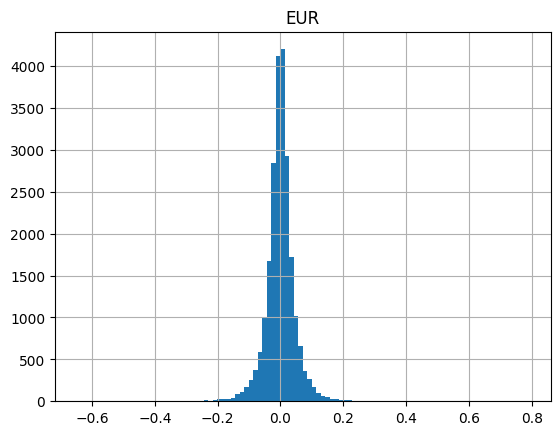

In [353]:
X_train.hist(bins=100);

## Normalization

In [78]:
from sklearn.preprocessing import MinMaxScaler

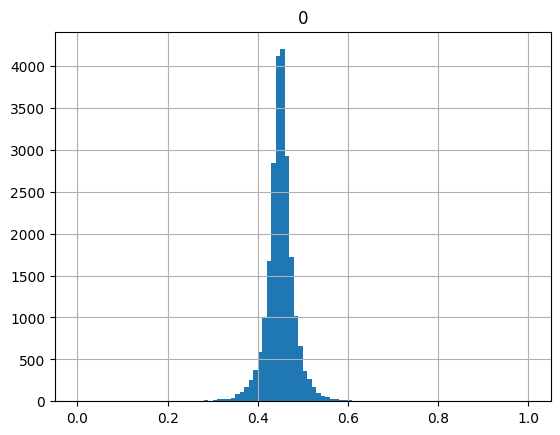

In [79]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
pd.DataFrame(X_train_scaled).hist(bins=100);

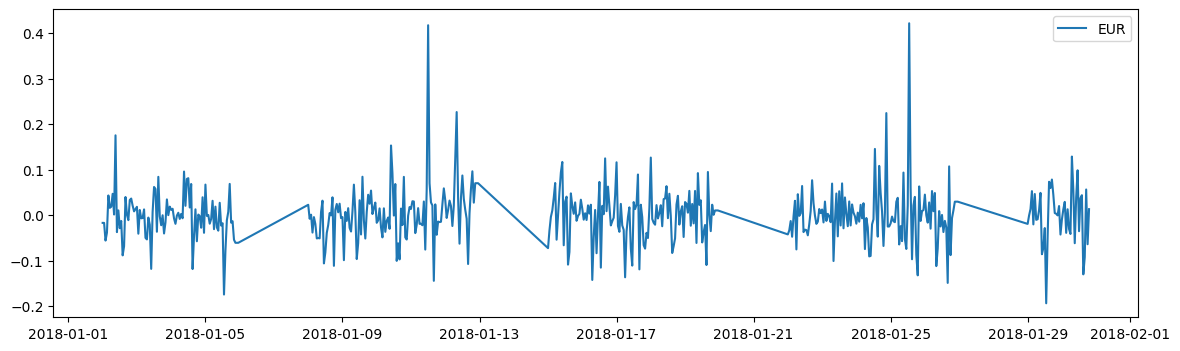

In [80]:
plt.figure(figsize=(14,4))
sns.lineplot(data=df_eur[0:500]);

## X_train and y_train

- 109.067 rows representing each hour in weekdays from 2005 to August 2022
- 8 columns representing the logarithmic return for each currency (AUD, CAD, CHF, EUR, GBP, JPY, NZD, USD)

The aim is to predict the logarithmic return for the next day (24h)

We will use $n$-day windows, with $n=6*21*24=1512$ initially (3 months by 21 days/month by 24h/day) and predict the next day (24 rows)

In [113]:
def create_train_test_windows(X: pd.DataFrame,
                              train_window: int,
                              test_window: int,
                              shift: int = 1,
                              gap: int = 0,
                              step: int = 1):
    '''
    X: TimeSeries DataFrame
    train_window: output rows for X_train
    test_window: output rows for X_tes
    shift: rows to shift to build y_train and y_test
    gap: row gap between train and test. If 0 the first value of X_test is equal to last value of y_train.
    step: row distance between consecutive windows
    
    Returns:
    X_train, X_test, y_train, y_test as ndarrays of DataFrames.
    '''
    
    X_train_dfs, X_test_dfs, y_train_dfs, y_test_dfs = [], [], [], []

    window = train_window + test_window + shift + gap

    for i in range(window, len(X), step):
        X_train_dfs.append(X[i - window: i - window + train_window])
        X_test_dfs.append(X[i - test_window - shift: i - shift])
        y_train_dfs.append(X[i - window + shift: i - window + train_window + shift])
        y_test_dfs.append(X[i - test_window: i])

    X_train_dfs = np.array(X_train_dfs)
    X_test_dfs = np.array(X_test_dfs)
    y_train_dfs = np.array(y_train_dfs)
    y_test_dfs = np.array(y_test_dfs)
    
    return X_train_dfs, X_test_dfs, y_train_dfs, y_test_dfs

Check if data is correct

In [114]:
train_window = 6 * 21 * 24 # rows in X
test_window = 24 # rows in y

X_trains, X_tests, y_trains, y_tests = create_train_test_windows(X_train_scaled, train_window=train_window, test_window=test_window, shift=1, gap=1, step=24)
X_trains.shape, X_tests.shape, y_trains.shape, y_tests.shape

((835, 3024, 1), (835, 24, 1), (835, 3024, 1), (835, 24, 1))

In [116]:
X_trains[0, -3:], y_trains[0, -3:], X_tests[0, :3], y_tests[0, :3]

(array([[0.45285467],
        [0.46239415],
        [0.4627367 ]]),
 array([[0.46239415],
        [0.4627367 ],
        [0.45993631]]),
 array([[0.51235751],
        [0.45893813],
        [0.44879269]]),
 array([[0.45893813],
        [0.44879269],
        [0.45069654]]))

## Create simple RNN model

In [118]:
def initialize_model(input_shape, output_size):
    
    regressor = Sequential()

    regressor.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(50, return_sequences=True))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(50, return_sequences=True))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(50))
    regressor.add(Dropout(0.2))

    regressor.add(Dense(output_size, activation="linear"))
    
    return regressor

In [58]:
def compile_model(model: Model,
                  optimizer:Union[str, Optimizer]='adam',
                  loss='mse',
                  metrics:list=['mae']):
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [131]:
def train_model(model: Model, X, y, X_val, y_val,
                epochs:int=10,
                batch_size:int=64,
                es:bool=False,
                callback=None):

    return model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[callback])

In [132]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = []

for X, X_val, y, y_val in zip(X_trains, X_tests, y_trains, y_tests):
    model = initialize_model(X.shape, 24)
    model = compile_model(model)
    history.append(train_model(model, X, y, X_val, y_val, epochs=10, batch_size=64, es=True, callback=es))
    break


Epoch 1/10
48/48 [==============================] - 4s 23ms/step - loss: 0.0719 - mae: 0.2152 - val_loss: 0.0032 - val_mae: 0.0443
Epoch 2/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0180 - mae: 0.1070 - val_loss: 0.0024 - val_mae: 0.0387
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0115 - mae: 0.0850 - val_loss: 0.0020 - val_mae: 0.0355
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0082 - mae: 0.0717 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 5/10
48/48 [==============================] - 1s 10ms/step - loss: 0.0066 - mae: 0.0639 - val_loss: 0.0016 - val_mae: 0.0330
Epoch 6/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0055 - mae: 0.0584 - val_loss: 0.0014 - val_mae: 0.0306
Epoch 7/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0050 - mae: 0.0553 - val_loss: 0.0015 - val_mae: 0.0323
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0046 - m

In [65]:
X_train_dfs.shape

(835, 3024, 1)

In [66]:
X_train_dfs[0]

array([[0.43841714],
       [0.43841714],
       [0.41135111],
       ...,
       [0.45285467],
       [0.46239415],
       [0.4627367 ]])

In [69]:
X_train_dfs[0][24 - 24: 24], X_train_dfs[0][24],

(array([[0.43841714],
        [0.43841714],
        [0.41135111],
        [0.42345713],
        [0.48039322],
        [0.46146529],
        [0.46312557],
        [0.4829428 ],
        [0.45122757],
        [0.57246269],
        [0.4243019 ],
        [0.45754262],
        [0.43024565],
        [0.44132976],
        [0.3886886 ],
        [0.40271603],
        [0.47802636],
        [0.45095477],
        [0.44263394],
        [0.47346052],
        [0.4756616 ],
        [0.46481404],
        [0.45606837],
        [0.45952995]]),
 array([0.46300924]))

In [ ]:
X_train_dfs_window = []
y_train_dfs_window = []

time_window = 24
step = 1
window = time_window

for i in range(window, len(X_train_dfs[0])):
    X_train_dfs_window.append(X_train_dfs[0][i - window: i])
    y_train_dfs_window.append(X_train_dfs[0][i])

X_train_dfs_window = np.array(X_train_dfs_window)
y_train_dfs_window = np.array(y_train_dfs_window)
X_train_dfs_window.shape, y_train_dfs_window.shape